# NB13: Statistical Arbitrage - Comprehensive Analysis

## Precog Quant Task 2026 - Part 4: Statistical Arbitrage Overlay

### Overview
This notebook investigates statistical arbitrage opportunities across 100 anonymized assets through:
1. **Correlation Analysis** - Identify co-moving asset pairs
2. **Cointegration Testing** - Find long-run equilibrium relationships
3. **Lead-Lag Analysis** - Discover predictive relationships
4. **Network Analysis** - Map asset interconnections
5. **Pairs Trading Strategy** - Mean reversion on cointegrated spreads

### Key Questions
- Which assets move together?
- Are relationships stable over time?
- Can we exploit mean-reverting spreads profitably after transaction costs?

---

In [2]:
# ============================================================================
# PART 1: SETUP AND DATA LOADING
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Paths
DATA_DIR = Path(r'c:\Users\ponna\OneDrive\Desktop\Precog Task\data\raw\assets')
OUTPUT_DIR = Path(r'c:\Users\ponna\OneDrive\Desktop\Precog Task\research\outputs\stat_arb')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("="*100)
print("📊 NB13: STATISTICAL ARBITRAGE ANALYSIS")
print("="*100)

📊 NB13: STATISTICAL ARBITRAGE ANALYSIS


In [3]:
# ============================================================================
# LOAD ALL 100 ASSETS
# ============================================================================

print("\n📁 Loading 100 assets...")

asset_files = sorted(DATA_DIR.glob('Asset_*.csv'))
print(f"   Found {len(asset_files)} asset files")

# Load close prices
close_prices = {}
volume_data = {}

for f in asset_files:
    ticker = f.stem
    df = pd.read_csv(f, parse_dates=['Date'], index_col='Date')
    close_prices[ticker] = df['Close']
    volume_data[ticker] = df['Volume']

# Build DataFrames
prices = pd.DataFrame(close_prices)
returns = prices.pct_change().dropna()
log_prices = np.log(prices)

# IS/OOS Split (OOS = 2024-2026)
oos_start = '2024-01-01'
prices_is = prices[prices.index < oos_start]
prices_oos = prices[prices.index >= oos_start]
returns_is = returns[returns.index < oos_start]
returns_oos = returns[returns.index >= oos_start]
log_prices_is = log_prices[log_prices.index < oos_start]
log_prices_oos = log_prices[log_prices.index >= oos_start]

print(f"\n📅 Data Summary:")
print(f"   Full period: {prices.index[0].date()} to {prices.index[-1].date()}")
print(f"   IS period:   {prices_is.index[0].date()} to {prices_is.index[-1].date()} ({len(prices_is)} days)")
print(f"   OOS period:  {prices_oos.index[0].date()} to {prices_oos.index[-1].date()} ({len(prices_oos)} days)")
print(f"   Assets:      {len(prices.columns)}")


📁 Loading 100 assets...
   Found 100 asset files

📅 Data Summary:
   Full period: 2016-01-25 to 2026-01-16
   IS period:   2016-01-25 to 2023-12-29 (1998 days)
   OOS period:  2024-01-02 to 2026-01-16 (513 days)
   Assets:      100


---
## Part 2: Correlation Analysis

We start by computing pairwise correlations between all 100 assets to identify highly correlated pairs.

In [4]:
# ============================================================================
# PART 2: PAIRWISE CORRELATION ANALYSIS
# ============================================================================

print("="*100)
print("📊 PART 2: CORRELATION ANALYSIS")
print("="*100)

# Compute correlation matrix on IS returns
corr_matrix = returns_is.corr()

# Extract upper triangle (exclude diagonal)
corr_pairs = []
n_assets = len(corr_matrix.columns)

for i in range(n_assets):
    for j in range(i + 1, n_assets):
        asset1 = corr_matrix.columns[i]
        asset2 = corr_matrix.columns[j]
        corr = corr_matrix.iloc[i, j]
        corr_pairs.append({'asset1': asset1, 'asset2': asset2, 'correlation': corr})

corr_df = pd.DataFrame(corr_pairs)
corr_df = corr_df.sort_values('correlation', ascending=False)

print(f"\n📊 Total pairs analyzed: {len(corr_df):,} (100 choose 2 = 4,950)")
print(f"\n📊 Correlation Distribution:")
print(corr_df['correlation'].describe())

# Identify highly correlated pairs
high_corr_threshold = 0.80
high_corr_pairs = corr_df[corr_df['correlation'] > high_corr_threshold]
print(f"\n📊 Highly Correlated Pairs (r > {high_corr_threshold}): {len(high_corr_pairs)}")
print(high_corr_pairs.head(20).to_string())

📊 PART 2: CORRELATION ANALYSIS

📊 Total pairs analyzed: 4,950 (100 choose 2 = 4,950)

📊 Correlation Distribution:
count    4950.000000
mean        0.399100
std         0.120450
min         0.075652
25%         0.313983
50%         0.393053
75%         0.475540
max         0.906497
Name: correlation, dtype: float64

📊 Highly Correlated Pairs (r > 0.8): 18
         asset1     asset2  correlation
860   Asset_010  Asset_016     0.906497
1222  Asset_014  Asset_028     0.905247
2371  Asset_028  Asset_078     0.878520
1272  Asset_014  Asset_078     0.870573
4389  Asset_067  Asset_068     0.869060
2361  Asset_028  Asset_068     0.847892
2335  Asset_028  Asset_042     0.839413
1129  Asset_013  Asset_021     0.835559
1262  Asset_014  Asset_068     0.835504
2360  Asset_028  Asset_067     0.833792
3327  Asset_043  Asset_074     0.832313
1261  Asset_014  Asset_067     0.827382
4431  Asset_068  Asset_078     0.827054
4399  Asset_067  Asset_078     0.822335
1236  Asset_014  Asset_042     0.816505
174

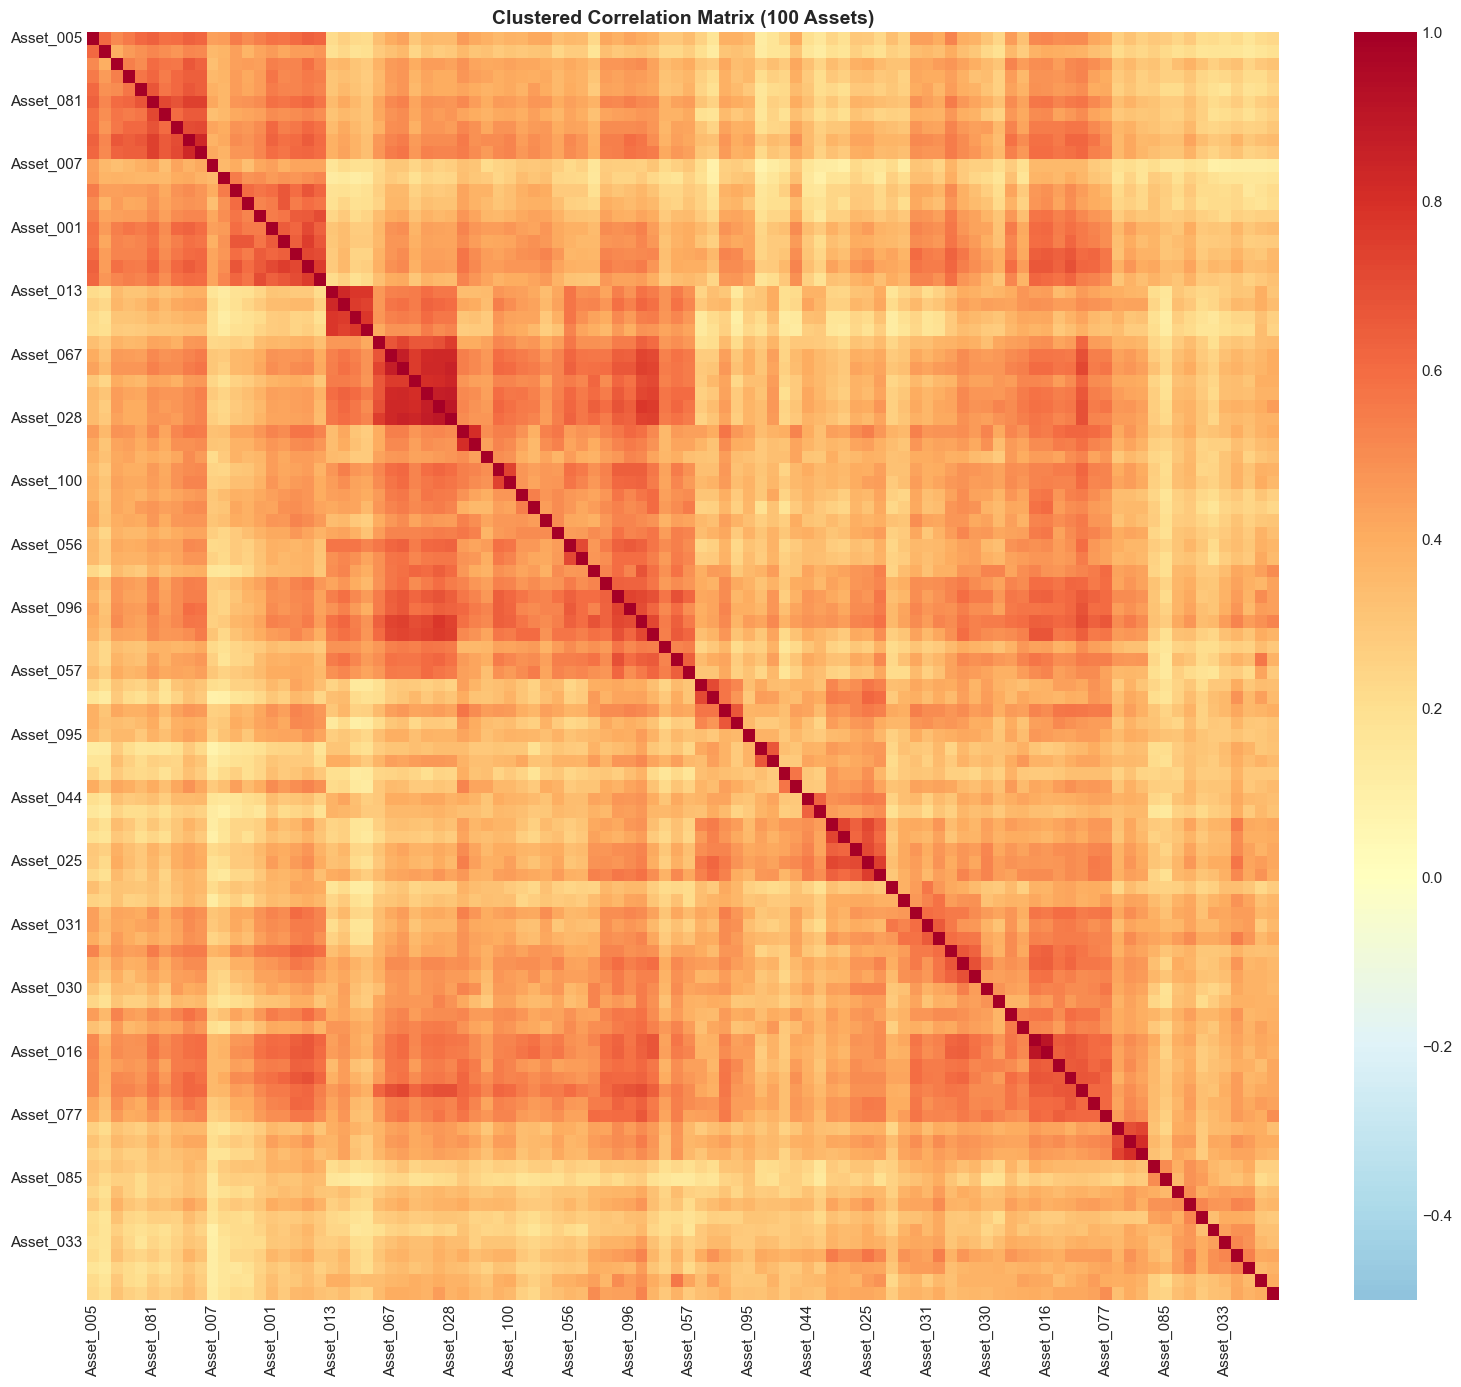


✅ Saved: correlation_matrix_clustered.png


In [5]:
# ============================================================================
# CORRELATION MATRIX HEATMAP
# ============================================================================

# Cluster the correlation matrix for better visualization
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

# Convert correlation to distance
distance_matrix = np.sqrt(2 * (1 - corr_matrix))
np.fill_diagonal(distance_matrix.values, 0)

# Hierarchical clustering
condensed_dist = squareform(distance_matrix)
linkage_matrix = linkage(condensed_dist, method='ward')

# Get optimal ordering
from scipy.cluster.hierarchy import leaves_list
order = leaves_list(linkage_matrix)
ordered_tickers = [corr_matrix.columns[i] for i in order]

# Reorder correlation matrix
corr_ordered = corr_matrix.loc[ordered_tickers, ordered_tickers]

# Plot
fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(corr_ordered, cmap='RdYlBu_r', center=0, 
            vmin=-0.5, vmax=1, ax=ax,
            xticklabels=5, yticklabels=5)
ax.set_title('Clustered Correlation Matrix (100 Assets)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'correlation_matrix_clustered.png', dpi=150)
plt.show()

print("\n✅ Saved: correlation_matrix_clustered.png")


📊 ROLLING CORRELATION ANALYSIS

📊 Analyzing stability of top 5 pairs...


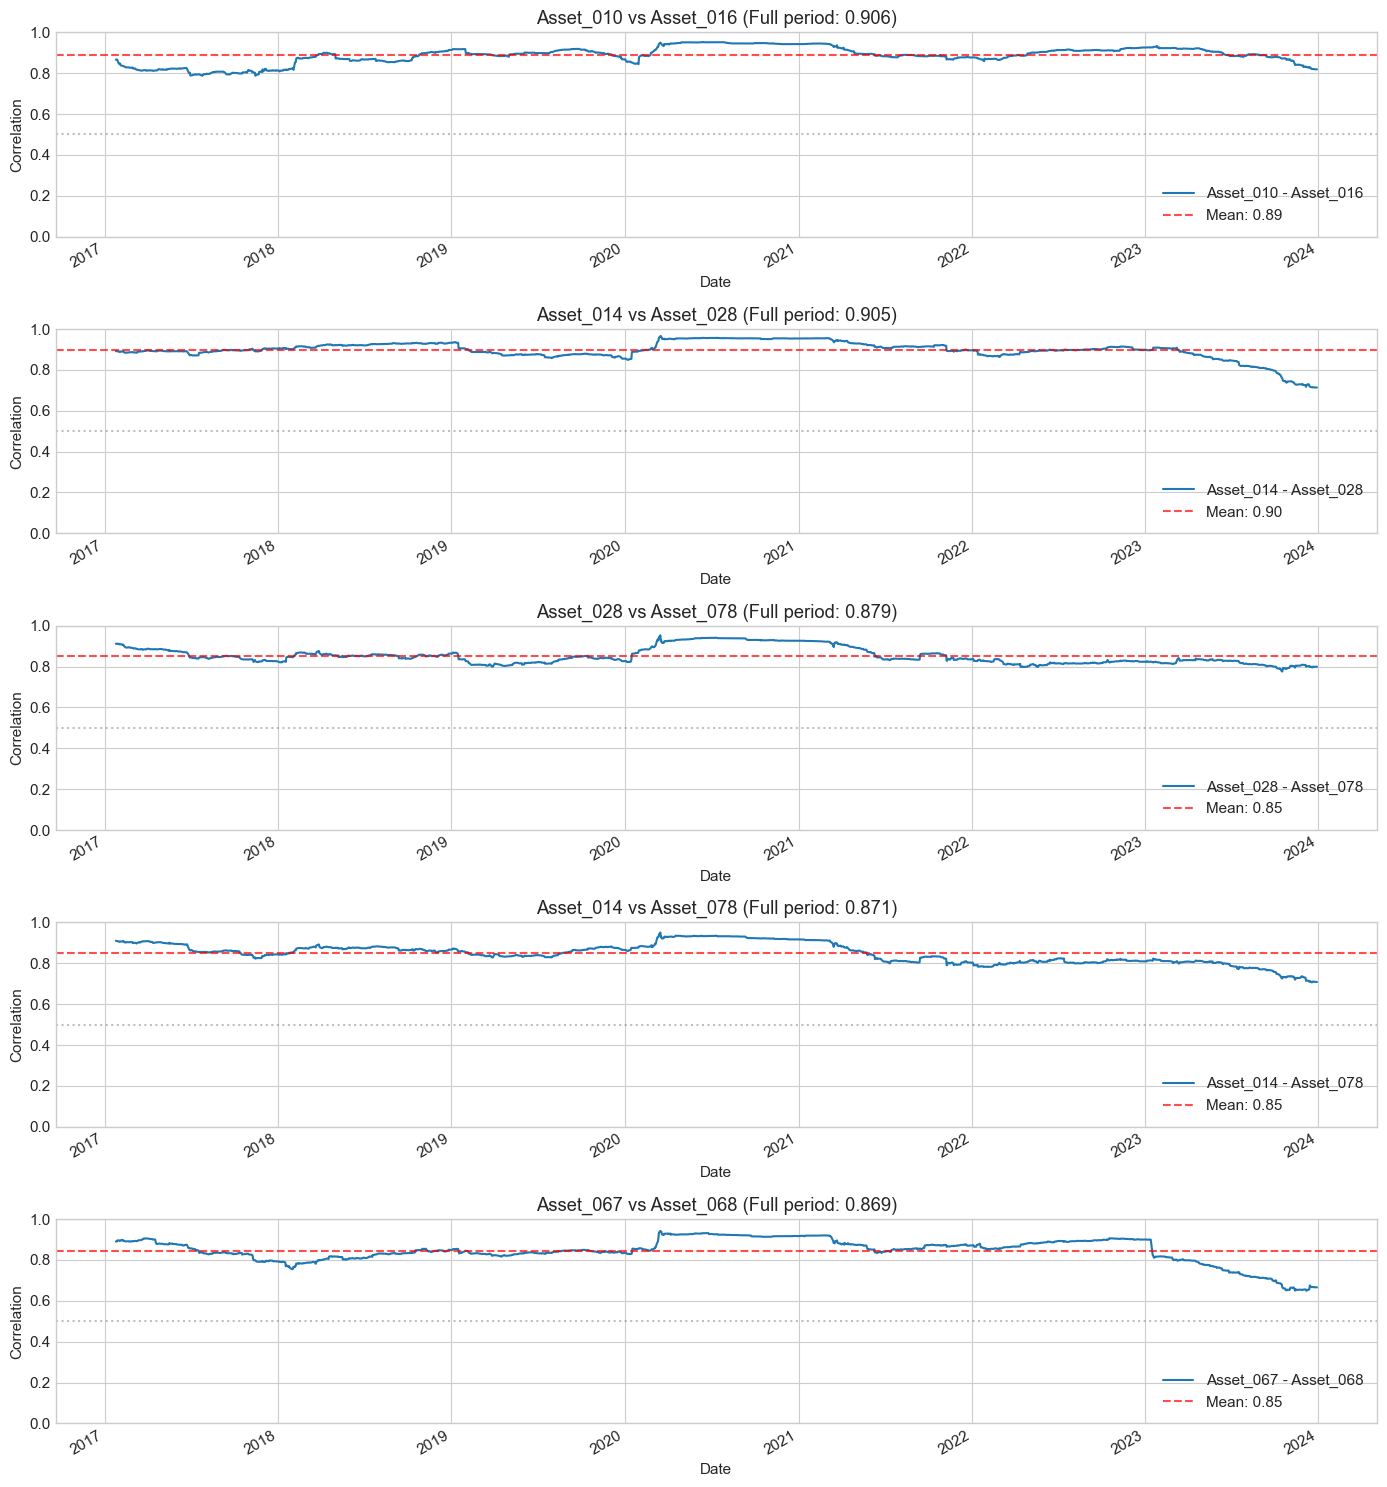


📊 Rolling Correlation Stability:
               pair  full_corr  rolling_mean  rolling_std  rolling_min  rolling_max  stability
Asset_010-Asset_016   0.906497      0.887690     0.041476     0.787318     0.952315  21.402349
Asset_014-Asset_028   0.905247      0.897263     0.044439     0.713566     0.966007  20.191062
Asset_028-Asset_078   0.878520      0.852734     0.040649     0.775776     0.953381  20.977766
Asset_014-Asset_078   0.870573      0.848959     0.049536     0.706595     0.950547  17.138194
Asset_067-Asset_068   0.869060      0.845403     0.060014     0.649277     0.942323  14.086713


In [6]:
# ============================================================================
# ROLLING CORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*100)
print("📊 ROLLING CORRELATION ANALYSIS")
print("="*100)

# Select top 5 most correlated pairs for rolling analysis
top_pairs = high_corr_pairs.head(5)
print(f"\n📊 Analyzing stability of top {len(top_pairs)} pairs...")

window = 252  # 1 year

fig, axes = plt.subplots(len(top_pairs), 1, figsize=(14, 3 * len(top_pairs)))

rolling_corr_results = []

for idx, (_, row) in enumerate(top_pairs.iterrows()):
    a1, a2 = row['asset1'], row['asset2']
    
    # Calculate rolling correlation
    rolling_corr = returns_is[a1].rolling(window).corr(returns_is[a2])
    
    # Statistics
    mean_corr = rolling_corr.mean()
    std_corr = rolling_corr.std()
    min_corr = rolling_corr.min()
    max_corr = rolling_corr.max()
    
    rolling_corr_results.append({
        'pair': f"{a1}-{a2}",
        'full_corr': row['correlation'],
        'rolling_mean': mean_corr,
        'rolling_std': std_corr,
        'rolling_min': min_corr,
        'rolling_max': max_corr,
        'stability': mean_corr / std_corr if std_corr > 0 else np.inf
    })
    
    # Plot
    ax = axes[idx] if len(top_pairs) > 1 else axes
    rolling_corr.plot(ax=ax, label=f'{a1} - {a2}')
    ax.axhline(mean_corr, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_corr:.2f}')
    ax.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
    ax.set_ylabel('Correlation')
    ax.set_title(f'{a1} vs {a2} (Full period: {row["correlation"]:.3f})')
    ax.legend(loc='lower right')
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'rolling_correlation_top_pairs.png', dpi=150)
plt.show()

# Summary table
rolling_df = pd.DataFrame(rolling_corr_results)
print("\n📊 Rolling Correlation Stability:")
print(rolling_df.to_string(index=False))

---
## Part 3: Cointegration Testing

High correlation doesn't guarantee profitability. We need **cointegration** - a long-run equilibrium relationship where the spread is mean-reverting.

In [7]:
# ============================================================================
# PART 3: COINTEGRATION TESTING
# ============================================================================

print("="*100)
print("📊 PART 3: COINTEGRATION TESTING (ENGLE-GRANGER)")
print("="*100)

def test_cointegration(price1, price2, significance=0.05):
    """
    Test for cointegration using Engle-Granger two-step method.
    
    Returns:
        dict with hedge_ratio, adf_stat, p_value, is_cointegrated, half_life
    """
    # Step 1: OLS regression to get hedge ratio
    X = add_constant(price1)
    model = OLS(price2, X).fit()
    hedge_ratio = model.params.iloc[1]
    intercept = model.params.iloc[0]
    
    # Calculate spread
    spread = price2 - hedge_ratio * price1 - intercept
    
    # Step 2: ADF test on spread
    adf_result = adfuller(spread.dropna(), maxlag=21, autolag='AIC')
    adf_stat = adf_result[0]
    p_value = adf_result[1]
    
    # Calculate half-life of mean reversion
    spread_lag = spread.shift(1).dropna()
    spread_diff = spread.diff().dropna()
    common_idx = spread_lag.index.intersection(spread_diff.index)
    
    if len(common_idx) > 30:
        X_hl = add_constant(spread_lag.loc[common_idx])
        y_hl = spread_diff.loc[common_idx]
        hl_model = OLS(y_hl, X_hl).fit()
        theta = hl_model.params.iloc[1]
        half_life = -np.log(2) / theta if theta < 0 else np.inf
    else:
        half_life = np.inf
    
    return {
        'hedge_ratio': hedge_ratio,
        'intercept': intercept,
        'adf_stat': adf_stat,
        'p_value': p_value,
        'is_cointegrated': p_value < significance,
        'half_life': half_life,
        'spread_std': spread.std()
    }

# Test all pairs with high correlation (to reduce computation)
# We'll test pairs with correlation > 0.5
test_pairs = corr_df[corr_df['correlation'] > 0.5].copy()
print(f"\n🔄 Testing {len(test_pairs)} pairs with correlation > 0.5...")

coint_results = []

for idx, row in test_pairs.iterrows():
    a1, a2 = row['asset1'], row['asset2']
    
    try:
        result = test_cointegration(log_prices_is[a1], log_prices_is[a2])
        result['asset1'] = a1
        result['asset2'] = a2
        result['correlation'] = row['correlation']
        coint_results.append(result)
    except Exception as e:
        continue

coint_df = pd.DataFrame(coint_results)
coint_df = coint_df.sort_values('p_value')

print(f"\n📊 Cointegration Results Summary:")
print(f"   Total pairs tested: {len(coint_df)}")
print(f"   Cointegrated (p < 0.05): {coint_df['is_cointegrated'].sum()}")
print(f"   Cointegrated (p < 0.01): {(coint_df['p_value'] < 0.01).sum()}")

📊 PART 3: COINTEGRATION TESTING (ENGLE-GRANGER)

🔄 Testing 966 pairs with correlation > 0.5...

📊 Cointegration Results Summary:
   Total pairs tested: 966
   Cointegrated (p < 0.05): 320
   Cointegrated (p < 0.01): 114


In [8]:
# ============================================================================
# FILTER TRADEABLE PAIRS (5 < half-life < 60 days)
# ============================================================================

print("\n" + "="*100)
print("📊 FILTERING TRADEABLE PAIRS")
print("="*100)

# Tradeable criteria:
# 1. Cointegrated (p < 0.05)
# 2. Half-life between 5-60 days (tradeable mean reversion)
# 3. Spread std reasonable

tradeable = coint_df[
    (coint_df['is_cointegrated'] == True) &
    (coint_df['half_life'] > 5) &
    (coint_df['half_life'] < 60)
].copy()

tradeable = tradeable.sort_values('p_value')

print(f"\n📊 Tradeable Pairs: {len(tradeable)}")
print(f"\n📊 Top 20 Tradeable Pairs:")
display_cols = ['asset1', 'asset2', 'correlation', 'p_value', 'half_life', 'hedge_ratio']
print(tradeable[display_cols].head(20).to_string())


📊 FILTERING TRADEABLE PAIRS

📊 Tradeable Pairs: 150

📊 Top 20 Tradeable Pairs:
        asset1     asset2  correlation   p_value  half_life  hedge_ratio
276  Asset_054  Asset_087     0.598704  0.000001  23.533442     1.036054
188  Asset_020  Asset_037     0.619003  0.000015  24.806358     1.073629
622  Asset_081  Asset_096     0.539567  0.000020  21.180424     0.430399
0    Asset_010  Asset_016     0.906497  0.000023  19.452130     1.253622
943  Asset_031  Asset_062     0.502400  0.000060  32.402651     0.822024
739  Asset_071  Asset_089     0.523350  0.000078  31.180125     1.039313
61   Asset_027  Asset_032     0.704091  0.000135  34.455452     0.683610
614  Asset_037  Asset_052     0.540279  0.000174  34.903800     1.080128
336  Asset_038  Asset_087     0.582578  0.000183  33.606923     1.180134
274  Asset_020  Asset_054     0.598925  0.000224  36.128824     1.243092
371  Asset_020  Asset_060     0.576177  0.000236  34.857722     1.468623
392  Asset_002  Asset_020     0.572387  0.00


📊 VISUALIZING TOP COINTEGRATED PAIRS


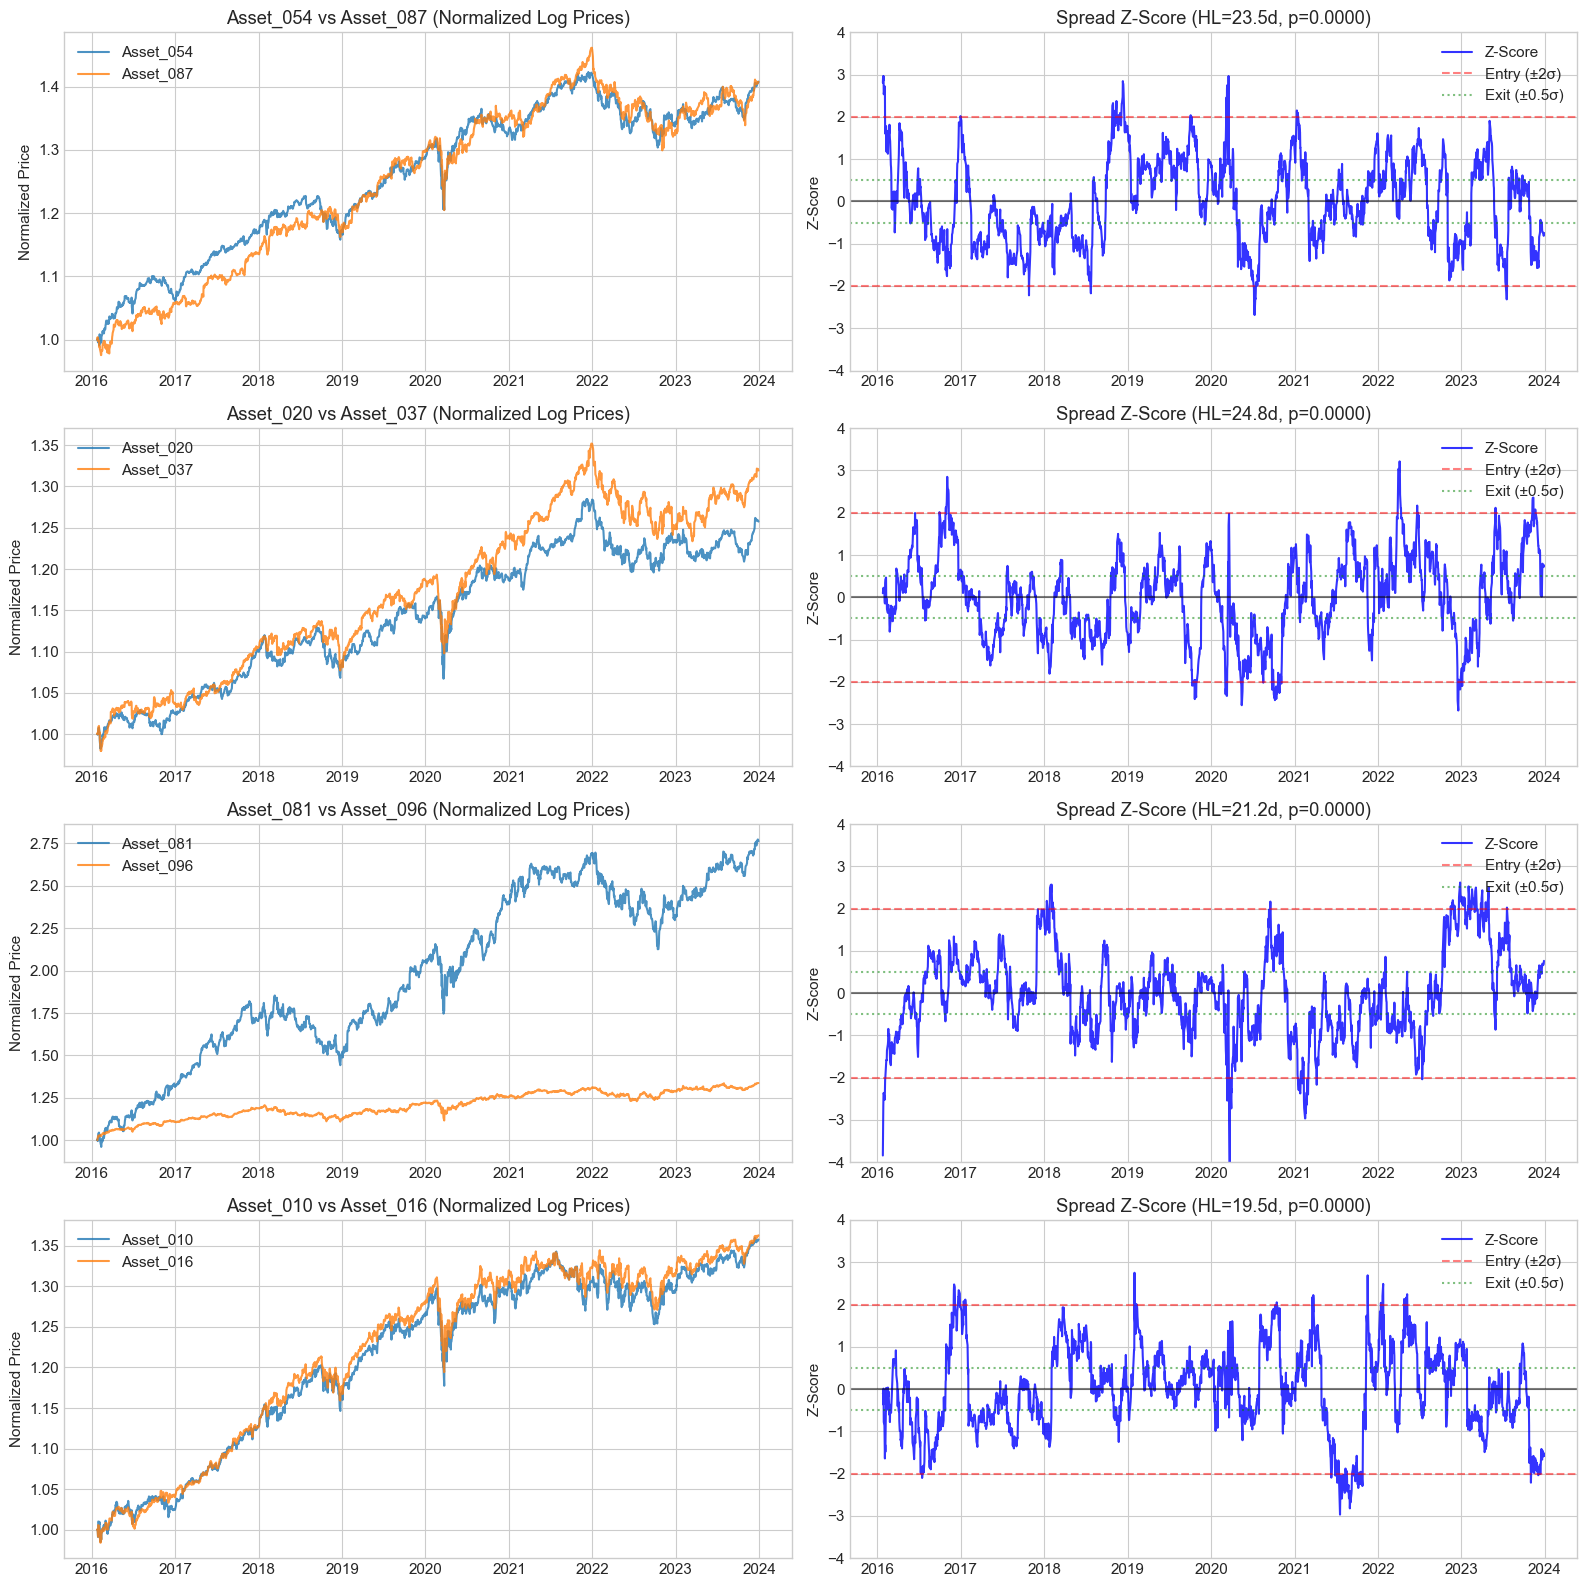


✅ Saved: top_cointegrated_pairs.png


In [9]:
# ============================================================================
# VISUALIZE TOP COINTEGRATED PAIRS
# ============================================================================

print("\n" + "="*100)
print("📊 VISUALIZING TOP COINTEGRATED PAIRS")
print("="*100)

# Select top 4 pairs to visualize
top_coint = tradeable.head(4)

fig, axes = plt.subplots(4, 2, figsize=(16, 16))

for idx, (_, row) in enumerate(top_coint.iterrows()):
    a1, a2 = row['asset1'], row['asset2']
    hedge = row['hedge_ratio']
    intercept = row['intercept']
    hl = row['half_life']
    
    # Calculate spread
    spread = log_prices_is[a2] - hedge * log_prices_is[a1] - intercept
    
    # Standardize spread
    z_spread = (spread - spread.mean()) / spread.std()
    
    # Left: Price series (normalized)
    ax_left = axes[idx, 0]
    norm1 = log_prices_is[a1] / log_prices_is[a1].iloc[0]
    norm2 = log_prices_is[a2] / log_prices_is[a2].iloc[0]
    ax_left.plot(norm1, label=a1, alpha=0.8)
    ax_left.plot(norm2, label=a2, alpha=0.8)
    ax_left.set_title(f'{a1} vs {a2} (Normalized Log Prices)')
    ax_left.legend()
    ax_left.set_ylabel('Normalized Price')
    
    # Right: Spread (z-score)
    ax_right = axes[idx, 1]
    ax_right.plot(z_spread, label='Z-Score', color='blue', alpha=0.8)
    ax_right.axhline(0, color='black', linestyle='-', alpha=0.5)
    ax_right.axhline(2, color='red', linestyle='--', alpha=0.5, label='Entry (±2σ)')
    ax_right.axhline(-2, color='red', linestyle='--', alpha=0.5)
    ax_right.axhline(0.5, color='green', linestyle=':', alpha=0.5, label='Exit (±0.5σ)')
    ax_right.axhline(-0.5, color='green', linestyle=':', alpha=0.5)
    ax_right.set_title(f'Spread Z-Score (HL={hl:.1f}d, p={row["p_value"]:.4f})')
    ax_right.legend(loc='upper right')
    ax_right.set_ylabel('Z-Score')
    ax_right.set_ylim(-4, 4)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'top_cointegrated_pairs.png', dpi=150)
plt.show()

print("\n✅ Saved: top_cointegrated_pairs.png")

---
## Part 4: Lead-Lag Analysis

Some assets may lead others - if Asset A's move today predicts Asset B's move tomorrow, we have a tradeable edge.

In [10]:
# ============================================================================
# PART 4: LEAD-LAG ANALYSIS
# ============================================================================

print("="*100)
print("📊 PART 4: LEAD-LAG ANALYSIS")
print("="*100)

def compute_lead_lag(ret1, ret2, max_lag=10):
    """
    Compute cross-correlation at different lags.
    Positive lag means ret1 leads ret2.
    """
    lags = range(-max_lag, max_lag + 1)
    correlations = []
    
    for lag in lags:
        if lag < 0:
            # ret2 leads
            corr = ret1.iloc[-lag:].corr(ret2.iloc[:lag])
        elif lag > 0:
            # ret1 leads
            corr = ret1.iloc[:-lag].corr(ret2.iloc[lag:])
        else:
            corr = ret1.corr(ret2)
        correlations.append(corr)
    
    return pd.Series(correlations, index=lags)

# Analyze top correlated pairs for lead-lag
print("\n🔄 Computing lead-lag relationships for top pairs...")

lead_lag_results = []

# Test pairs with high correlation
test_ll_pairs = high_corr_pairs.head(20)

for _, row in test_ll_pairs.iterrows():
    a1, a2 = row['asset1'], row['asset2']
    
    xcorr = compute_lead_lag(returns_is[a1], returns_is[a2], max_lag=5)
    
    # Find max correlation and its lag
    max_corr_lag = xcorr.idxmax()
    max_corr_val = xcorr.max()
    
    # Lead/lag asymmetry: corr(lag=1) - corr(lag=-1)
    asymmetry = xcorr.get(1, 0) - xcorr.get(-1, 0)
    
    lead_lag_results.append({
        'asset1': a1,
        'asset2': a2,
        'corr_lag0': xcorr.get(0, 0),
        'corr_lag1': xcorr.get(1, 0),
        'corr_lag_neg1': xcorr.get(-1, 0),
        'max_corr_lag': max_corr_lag,
        'asymmetry': asymmetry,
        'leader': a1 if asymmetry > 0 else a2
    })

lead_lag_df = pd.DataFrame(lead_lag_results)
lead_lag_df = lead_lag_df.sort_values('asymmetry', key=abs, ascending=False)

print("\n📊 Lead-Lag Asymmetry (|asymmetry| = strength of lead relationship):")
print(lead_lag_df.head(10).to_string())

📊 PART 4: LEAD-LAG ANALYSIS

🔄 Computing lead-lag relationships for top pairs...

📊 Lead-Lag Asymmetry (|asymmetry| = strength of lead relationship):
      asset1     asset2  corr_lag0  corr_lag1  corr_lag_neg1  max_corr_lag  asymmetry     leader
0  Asset_010  Asset_016   0.906497   0.906497       0.906497            -2        0.0  Asset_016
1  Asset_014  Asset_028   0.905247   0.905175       0.905175            -3        0.0  Asset_028
2  Asset_028  Asset_078   0.878520   0.878454       0.878454            -3        0.0  Asset_078
3  Asset_014  Asset_078   0.870573   0.870494       0.870494             0        0.0  Asset_078
4  Asset_067  Asset_068   0.869060   0.868998       0.868998            -3        0.0  Asset_068
5  Asset_028  Asset_068   0.847892   0.847817       0.847817            -5        0.0  Asset_068
6  Asset_028  Asset_042   0.839413   0.839446       0.839446            -5        0.0  Asset_042
7  Asset_013  Asset_021   0.835559   0.835229       0.835229             0

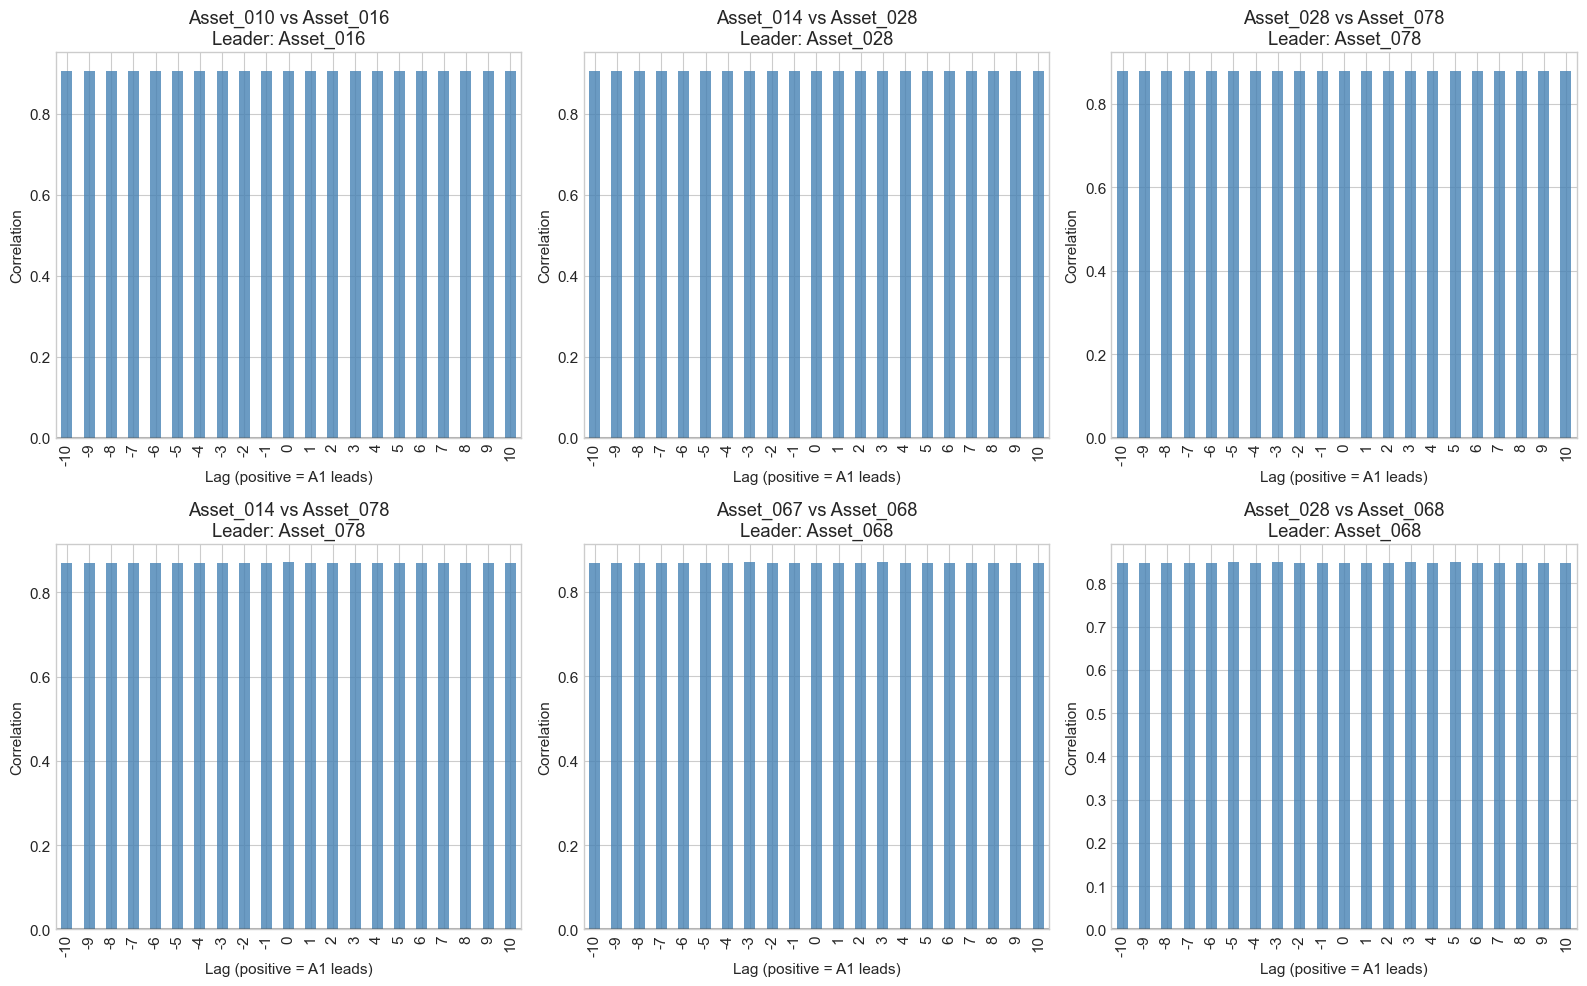


✅ Saved: lead_lag_analysis.png


In [11]:
# ============================================================================
# VISUALIZE LEAD-LAG PATTERNS
# ============================================================================

# Plot cross-correlation functions for top pairs
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, row in lead_lag_df.head(6).iterrows():
    a1, a2 = row['asset1'], row['asset2']
    xcorr = compute_lead_lag(returns_is[a1], returns_is[a2], max_lag=10)
    
    ax = axes[idx]
    xcorr.plot(kind='bar', ax=ax, color='steelblue', alpha=0.8)
    ax.axhline(0, color='black', linestyle='-', alpha=0.3)
    ax.set_title(f'{a1} vs {a2}\nLeader: {row["leader"]}')
    ax.set_xlabel('Lag (positive = A1 leads)')
    ax.set_ylabel('Correlation')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'lead_lag_analysis.png', dpi=150)
plt.show()

print("\n✅ Saved: lead_lag_analysis.png")

---
## Part 5: Network Analysis

Build a network where edges represent cointegration relationships to identify clusters of co-moving assets.

In [12]:
# ============================================================================
# PART 5: NETWORK ANALYSIS
# ============================================================================

print("="*100)
print("📊 PART 5: COINTEGRATION NETWORK ANALYSIS")
print("="*100)

try:
    import networkx as nx
    
    # Build network from cointegrated pairs
    G = nx.Graph()
    
    # Add all assets as nodes
    G.add_nodes_from(prices.columns)
    
    # Add edges for cointegrated pairs
    for _, row in coint_df[coint_df['is_cointegrated']].iterrows():
        G.add_edge(
            row['asset1'], row['asset2'],
            weight=1 - row['p_value'],  # Higher weight for lower p-value
            p_value=row['p_value'],
            half_life=row['half_life']
        )
    
    print(f"\n📊 Network Statistics:")
    print(f"   Nodes (assets): {G.number_of_nodes()}")
    print(f"   Edges (cointegrated pairs): {G.number_of_edges()}")
    print(f"   Network density: {nx.density(G):.4f}")
    
    # Find connected components
    components = list(nx.connected_components(G))
    print(f"   Connected components: {len(components)}")
    
    # Find largest component
    largest_cc = max(components, key=len)
    print(f"   Largest component: {len(largest_cc)} assets")
    
    # Identify most connected assets (hubs)
    degree_centrality = nx.degree_centrality(G)
    top_hubs = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    
    print(f"\n📊 Top 10 Hub Assets (most cointegration connections):")
    for asset, centrality in top_hubs:
        n_connections = G.degree(asset)
        print(f"   {asset}: {n_connections} cointegrated pairs (centrality: {centrality:.3f})")

except ImportError:
    print("\n⚠️ NetworkX not installed. Skipping network analysis.")
    print("   Install with: pip install networkx")

📊 PART 5: COINTEGRATION NETWORK ANALYSIS

📊 Network Statistics:
   Nodes (assets): 100
   Edges (cointegrated pairs): 320
   Network density: 0.0646
   Connected components: 23
   Largest component: 78 assets

📊 Top 10 Hub Assets (most cointegration connections):
   Asset_037: 27 cointegrated pairs (centrality: 0.273)
   Asset_020: 23 cointegrated pairs (centrality: 0.232)
   Asset_054: 22 cointegrated pairs (centrality: 0.222)
   Asset_074: 21 cointegrated pairs (centrality: 0.212)
   Asset_078: 21 cointegrated pairs (centrality: 0.212)
   Asset_002: 20 cointegrated pairs (centrality: 0.202)
   Asset_064: 20 cointegrated pairs (centrality: 0.202)
   Asset_035: 18 cointegrated pairs (centrality: 0.182)
   Asset_043: 18 cointegrated pairs (centrality: 0.182)
   Asset_049: 18 cointegrated pairs (centrality: 0.182)


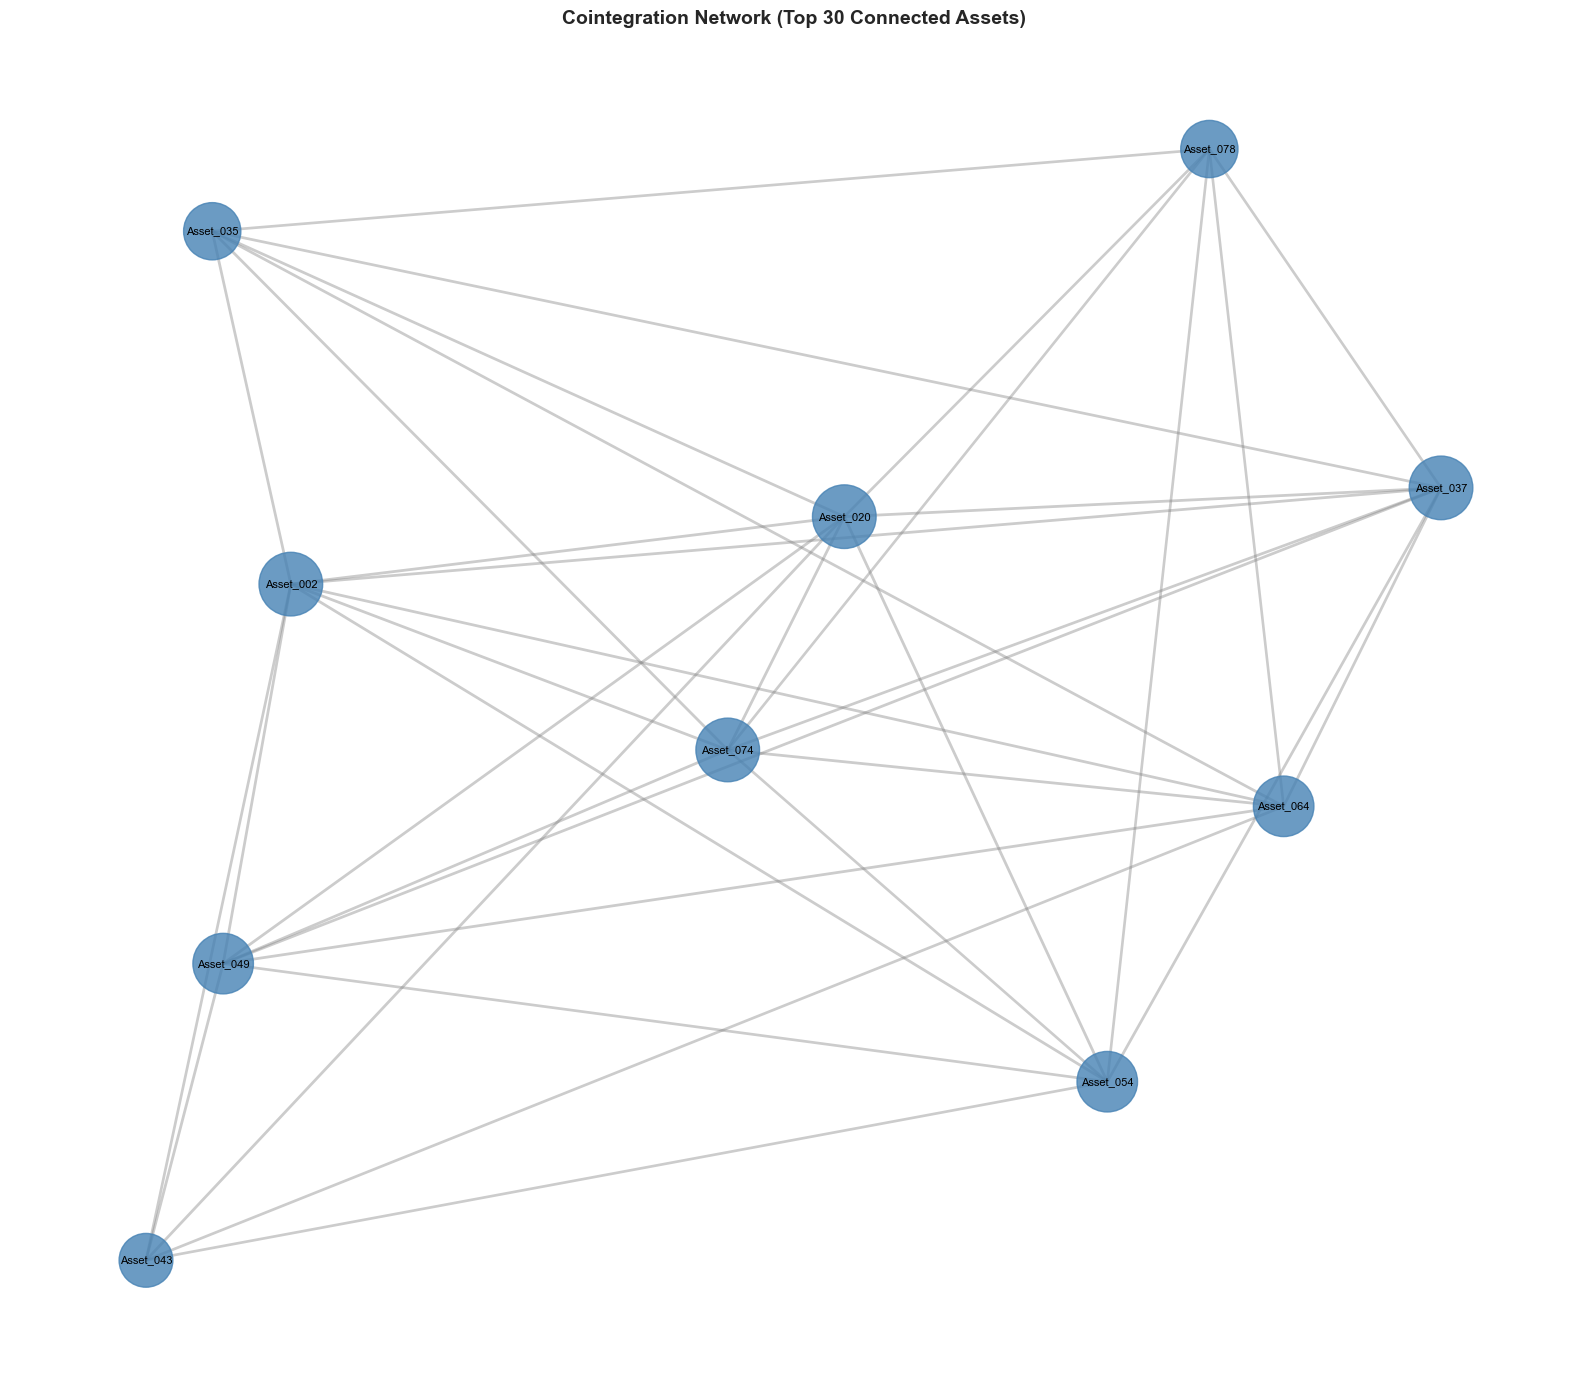


✅ Saved: cointegration_network.png


In [13]:
# ============================================================================
# VISUALIZE COINTEGRATION NETWORK
# ============================================================================

try:
    # Create subgraph of most connected nodes
    top_nodes = [node for node, _ in top_hubs[:30]]
    subG = G.subgraph(top_nodes)
    
    # Layout
    pos = nx.spring_layout(subG, k=2, iterations=50, seed=42)
    
    # Node sizes based on degree
    node_sizes = [500 + 200 * subG.degree(node) for node in subG.nodes()]
    
    # Edge weights
    edge_weights = [subG[u][v]['weight'] * 2 for u, v in subG.edges()]
    
    # Plot
    fig, ax = plt.subplots(figsize=(16, 14))
    
    nx.draw_networkx_nodes(subG, pos, node_size=node_sizes, 
                          node_color='steelblue', alpha=0.8, ax=ax)
    nx.draw_networkx_labels(subG, pos, font_size=8, ax=ax)
    nx.draw_networkx_edges(subG, pos, width=edge_weights, 
                          alpha=0.4, edge_color='gray', ax=ax)
    
    ax.set_title('Cointegration Network (Top 30 Connected Assets)', fontsize=14, fontweight='bold')
    ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'cointegration_network.png', dpi=150)
    plt.show()
    
    print("\n✅ Saved: cointegration_network.png")

except:
    print("\n⚠️ Could not visualize network.")

---
## Part 6: Pairs Trading Strategy Backtest

Now we implement a mean-reversion pairs trading strategy on the best cointegrated pairs.

In [14]:
# ============================================================================
# PART 6: PAIRS TRADING STRATEGY
# ============================================================================

print("="*100)
print("📊 PART 6: PAIRS TRADING STRATEGY BACKTEST")
print("="*100)

def backtest_pairs_strategy(prices_1, prices_2, hedge_ratio, intercept, 
                            entry_z=2.0, exit_z=0.5, stop_z=4.0,
                            lookback=63, tc_bps=10):
    """
    Backtest a pairs trading strategy on a single pair.
    
    Entry: |z-score| > entry_z
    Exit: |z-score| < exit_z OR stop-loss at |z-score| > stop_z
    """
    # Calculate spread using log prices
    log_p1 = np.log(prices_1)
    log_p2 = np.log(prices_2)
    spread = log_p2 - hedge_ratio * log_p1 - intercept
    
    # Rolling z-score
    rolling_mean = spread.rolling(lookback).mean()
    rolling_std = spread.rolling(lookback).std()
    z_score = (spread - rolling_mean) / rolling_std
    
    # Returns
    ret1 = prices_1.pct_change()
    ret2 = prices_2.pct_change()
    
    # Initialize
    position = 0  # -1 = short spread, 0 = flat, +1 = long spread
    pnl = []
    positions = []
    tc_costs = []
    
    for i in range(lookback + 1, len(z_score)):
        z = z_score.iloc[i]
        r1 = ret1.iloc[i]
        r2 = ret2.iloc[i]
        
        tc_cost = 0
        
        if pd.isna(z) or pd.isna(r1) or pd.isna(r2):
            pnl.append(0)
            positions.append(position)
            tc_costs.append(0)
            continue
        
        # Check for entry/exit
        if position == 0:  # Flat
            if z > entry_z:  # Spread too high -> short spread (short asset2, long asset1)
                position = -1
                tc_cost = tc_bps / 10000 * 2
            elif z < -entry_z:  # Spread too low -> long spread (long asset2, short asset1)
                position = 1
                tc_cost = tc_bps / 10000 * 2
        
        elif position == 1:  # Long spread
            if z > -exit_z or z > stop_z:  # Exit
                position = 0
                tc_cost = tc_bps / 10000 * 2
        
        elif position == -1:  # Short spread
            if z < exit_z or z < -stop_z:  # Exit
                position = 0
                tc_cost = tc_bps / 10000 * 2
        
        # Calculate P&L
        # Long spread = long asset2, short asset1 (hedge ratio units)
        # PnL = r2 - hedge_ratio * r1
        if position == 1:
            daily_pnl = r2 - hedge_ratio * r1
        elif position == -1:
            daily_pnl = -(r2 - hedge_ratio * r1)
        else:
            daily_pnl = 0
        
        pnl.append(daily_pnl - tc_cost)
        positions.append(position)
        tc_costs.append(tc_cost)
    
    # Prepare results
    results_idx = z_score.index[lookback + 1:]
    pnl_series = pd.Series(pnl, index=results_idx)
    
    # Calculate metrics
    cumulative = (1 + pnl_series).cumprod()
    total_return = cumulative.iloc[-1] - 1
    sharpe = pnl_series.mean() / pnl_series.std() * np.sqrt(252) if pnl_series.std() > 0 else 0
    max_dd = (cumulative / cumulative.cummax() - 1).min()
    n_trades = sum(1 for i in range(1, len(positions)) if positions[i] != positions[i-1])
    total_tc = sum(tc_costs)
    
    return {
        'total_return': total_return,
        'sharpe': sharpe,
        'max_dd': max_dd,
        'n_trades': n_trades,
        'total_tc': total_tc,
        'pnl': pnl_series,
        'cumulative': cumulative
    }

📊 PART 6: PAIRS TRADING STRATEGY BACKTEST


In [15]:
# ============================================================================
# BACKTEST TOP PAIRS ON IS DATA
# ============================================================================

print("\n🔄 Backtesting top 10 tradeable pairs on IS data...")

backtest_results = []

for idx, row in tradeable.head(10).iterrows():
    a1, a2 = row['asset1'], row['asset2']
    hedge = row['hedge_ratio']
    intercept = row['intercept']
    
    result = backtest_pairs_strategy(
        prices_is[a1], prices_is[a2],
        hedge, intercept,
        entry_z=2.0, exit_z=0.5, stop_z=4.0,
        lookback=63, tc_bps=10
    )
    
    result['pair'] = f"{a1}-{a2}"
    result['half_life'] = row['half_life']
    result['p_value'] = row['p_value']
    backtest_results.append(result)

# Create summary DataFrame
bt_summary = pd.DataFrame([{
    'pair': r['pair'],
    'half_life': r['half_life'],
    'p_value': r['p_value'],
    'total_return': r['total_return'] * 100,
    'sharpe': r['sharpe'],
    'max_dd': r['max_dd'] * 100,
    'n_trades': r['n_trades']
} for r in backtest_results])

print("\n📊 IS Backtest Results:")
print(bt_summary.to_string(index=False))

# Identify best performing pairs
best_pairs = bt_summary[bt_summary['sharpe'] > 0].sort_values('sharpe', ascending=False)
print(f"\n✅ Profitable pairs (Sharpe > 0): {len(best_pairs)} out of {len(bt_summary)}")


🔄 Backtesting top 10 tradeable pairs on IS data...

📊 IS Backtest Results:
               pair  half_life  p_value  total_return    sharpe     max_dd  n_trades
Asset_054-Asset_087  23.533442 0.000001    -73.695850 -0.942168 -75.059058        76
Asset_020-Asset_037  24.806358 0.000015    -74.039210 -1.172369 -75.158455        71
Asset_081-Asset_096  21.180424 0.000020    -53.746180 -0.684088 -55.953835        68
Asset_010-Asset_016  19.452130 0.000023    -60.230588 -1.184119 -60.684689        72
Asset_031-Asset_062  32.402651 0.000060    -68.274857 -0.861229 -69.385269        71
Asset_071-Asset_089  31.180125 0.000078    -64.872934 -0.892698 -69.356925        64
Asset_027-Asset_032  34.455452 0.000135    -77.338409 -0.948835 -77.653429        61
Asset_037-Asset_052  34.903800 0.000174    -79.779643 -1.021143 -80.091688        62
Asset_038-Asset_087  33.606923 0.000183    -79.392478 -1.078587 -80.845670        76
Asset_020-Asset_054  36.128824 0.000224    -75.229658 -0.918065 -77.601999

In [16]:
# ============================================================================
# OUT-OF-SAMPLE VALIDATION
# ============================================================================

print("\n" + "="*100)
print("📊 OUT-OF-SAMPLE VALIDATION")
print("="*100)

# Test the best IS pairs on OOS data
oos_results = []

for idx, row in tradeable.head(10).iterrows():
    a1, a2 = row['asset1'], row['asset2']
    
    # Re-estimate hedge ratio on IS data (no leakage)
    X = add_constant(log_prices_is[a1])
    model = OLS(log_prices_is[a2], X).fit()
    hedge = model.params.iloc[1]
    intercept = model.params.iloc[0]
    
    # Backtest on OOS
    result = backtest_pairs_strategy(
        prices_oos[a1], prices_oos[a2],
        hedge, intercept,
        entry_z=2.0, exit_z=0.5, stop_z=4.0,
        lookback=63, tc_bps=10
    )
    
    result['pair'] = f"{a1}-{a2}"
    oos_results.append(result)

# Summary
oos_summary = pd.DataFrame([{
    'pair': r['pair'],
    'oos_return': r['total_return'] * 100,
    'oos_sharpe': r['sharpe'],
    'oos_max_dd': r['max_dd'] * 100,
    'oos_trades': r['n_trades']
} for r in oos_results])

# Merge IS and OOS results
combined = bt_summary.merge(oos_summary, on='pair')

print("\n📊 IS vs OOS Comparison:")
print(combined[['pair', 'sharpe', 'oos_sharpe', 'total_return', 'oos_return']].to_string(index=False))

# Calculate stats
print(f"\n📊 Summary Statistics:")
print(f"   IS  mean Sharpe: {combined['sharpe'].mean():.2f}")
print(f"   OOS mean Sharpe: {combined['oos_sharpe'].mean():.2f}")
print(f"   Pairs with OOS Sharpe > 0: {(combined['oos_sharpe'] > 0).sum()} / {len(combined)}")


📊 OUT-OF-SAMPLE VALIDATION

📊 IS vs OOS Comparison:
               pair    sharpe  oos_sharpe  total_return  oos_return
Asset_054-Asset_087 -0.942168   -0.994148    -73.695850  -33.742619
Asset_020-Asset_037 -1.172369   -1.167667    -74.039210  -40.908975
Asset_081-Asset_096 -0.684088   -1.561135    -53.746180  -41.382436
Asset_010-Asset_016 -1.184119   -1.527744    -60.230588  -22.029010
Asset_031-Asset_062 -0.861229   -0.791251    -68.274857  -21.744451
Asset_071-Asset_089 -0.892698   -1.629291    -64.872934  -38.897673
Asset_027-Asset_032 -0.948835   -1.309100    -77.338409  -46.288707
Asset_037-Asset_052 -1.021143   -1.467943    -79.779643  -40.681279
Asset_038-Asset_087 -1.078587   -0.991145    -79.392478  -34.223865
Asset_020-Asset_054 -0.918065   -1.025829    -75.229658  -31.437471

📊 Summary Statistics:
   IS  mean Sharpe: -0.97
   OOS mean Sharpe: -1.25
   Pairs with OOS Sharpe > 0: 0 / 10


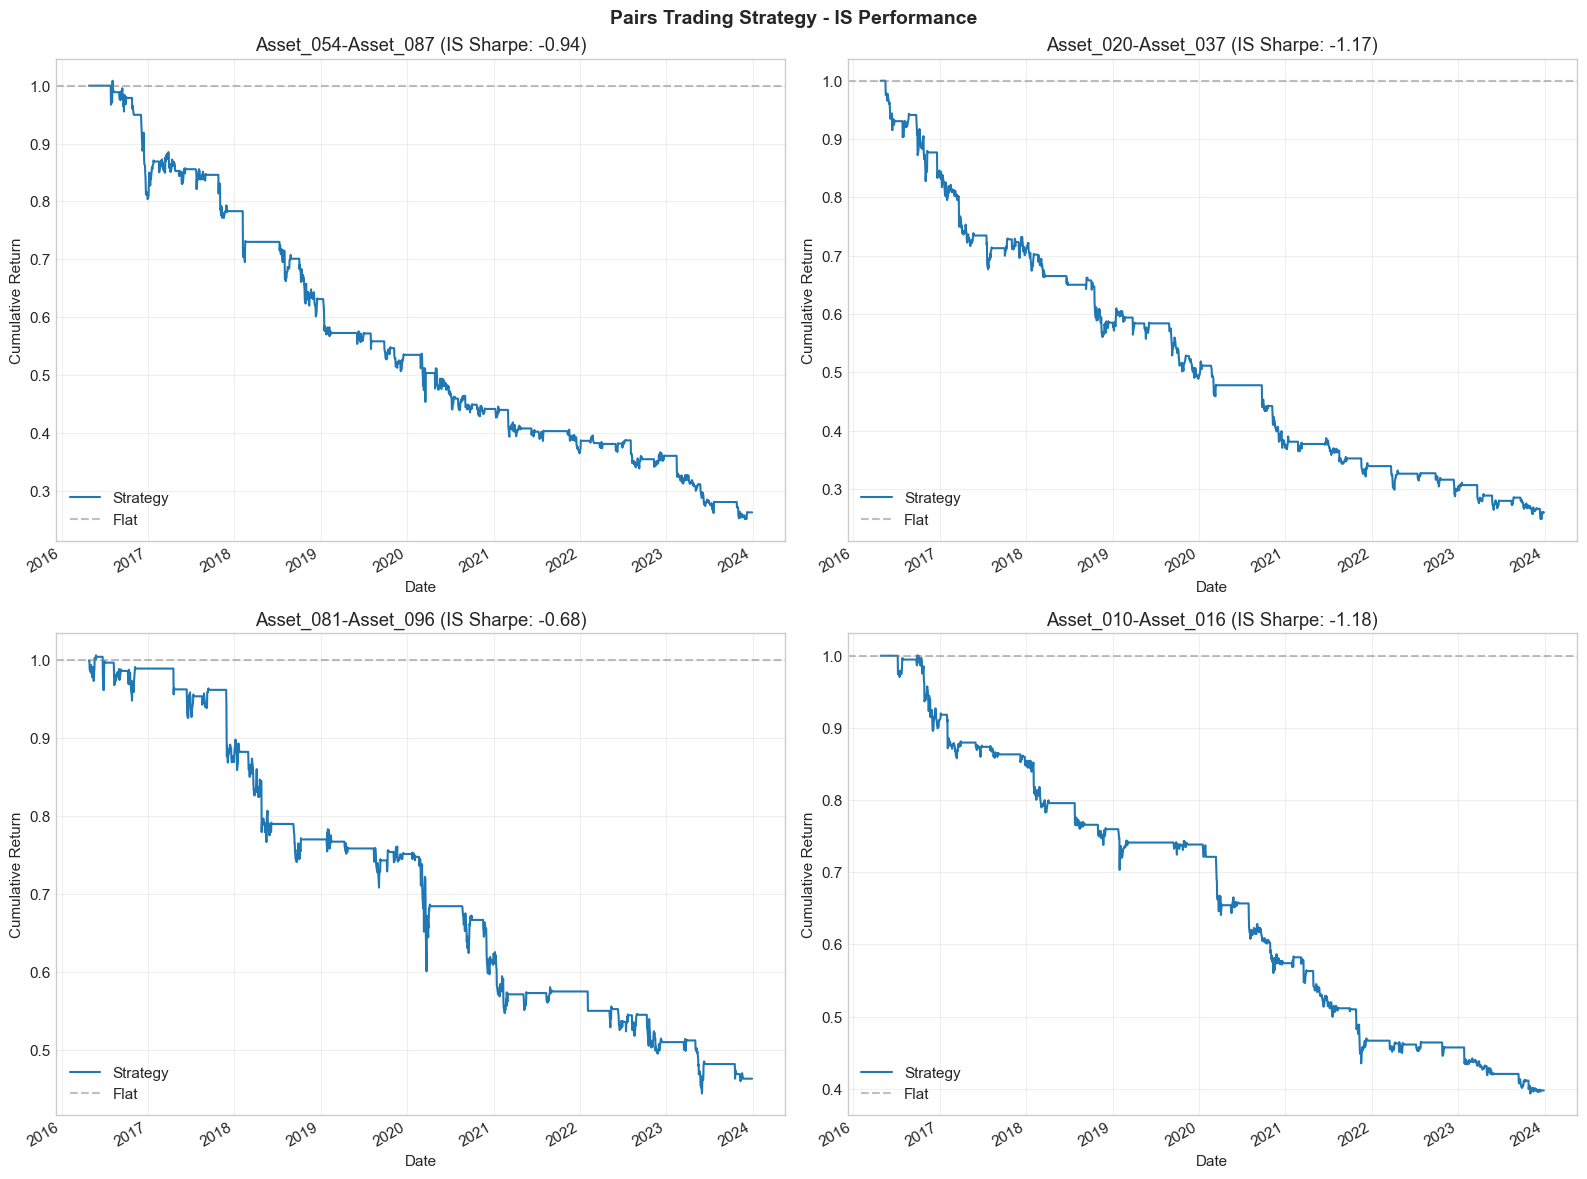


✅ Saved: pairs_strategy_equity.png


In [17]:
# ============================================================================
# VISUALIZE BEST PAIR'S PERFORMANCE
# ============================================================================

# Plot equity curves for top pairs
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, result in enumerate(backtest_results[:4]):
    ax = axes[idx // 2, idx % 2]
    
    cumulative = result['cumulative']
    cumulative.plot(ax=ax, label='Strategy', linewidth=1.5)
    
    ax.axhline(1, color='gray', linestyle='--', alpha=0.5, label='Flat')
    ax.set_title(f"{result['pair']} (IS Sharpe: {result['sharpe']:.2f})")
    ax.set_ylabel('Cumulative Return')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Pairs Trading Strategy - IS Performance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'pairs_strategy_equity.png', dpi=150)
plt.show()

print("\n✅ Saved: pairs_strategy_equity.png")

---
## Part 7: Stability Analysis

Test whether cointegration relationships are stable over time.

📊 PART 7: COINTEGRATION STABILITY ANALYSIS

🔍 Analyzing stability of Asset_054 - Asset_087...


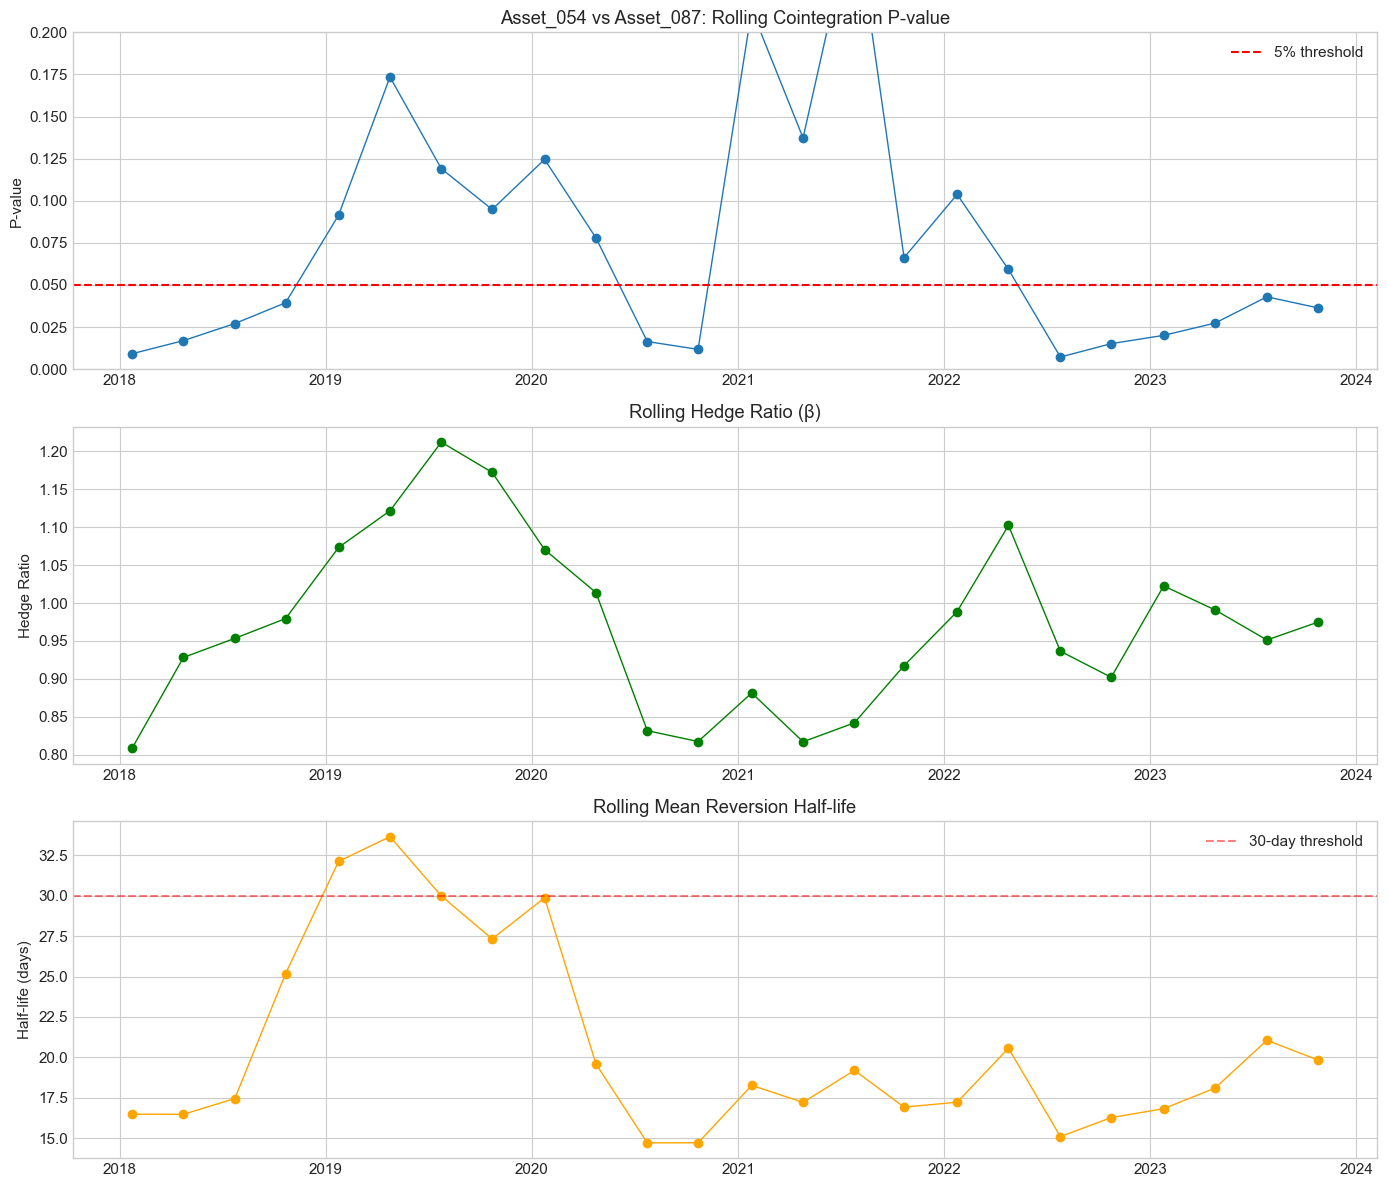


📊 Stability Summary for Asset_054 - Asset_087:
   Windows cointegrated: 50.0%
   Hedge ratio range: [0.81, 1.21]
   Half-life range: [14.7, 33.6] days

✅ Saved: cointegration_stability.png


In [18]:
# ============================================================================
# PART 7: COINTEGRATION STABILITY ANALYSIS
# ============================================================================

print("="*100)
print("📊 PART 7: COINTEGRATION STABILITY ANALYSIS")
print("="*100)

# Rolling cointegration test for top pair
top_pair = tradeable.iloc[0]
a1, a2 = top_pair['asset1'], top_pair['asset2']

print(f"\n🔍 Analyzing stability of {a1} - {a2}...")

# Rolling windows
window = 504  # 2 years
step = 63     # Quarterly

rolling_coint = []

dates = log_prices_is.index
for start_idx in range(0, len(dates) - window, step):
    end_idx = start_idx + window
    window_start = dates[start_idx]
    window_end = dates[end_idx - 1]
    
    p1 = log_prices_is[a1].iloc[start_idx:end_idx]
    p2 = log_prices_is[a2].iloc[start_idx:end_idx]
    
    result = test_cointegration(p1, p2)
    
    rolling_coint.append({
        'window_end': window_end,
        'p_value': result['p_value'],
        'hedge_ratio': result['hedge_ratio'],
        'half_life': min(result['half_life'], 100),
        'is_cointegrated': result['is_cointegrated']
    })

stability_df = pd.DataFrame(rolling_coint)
stability_df = stability_df.set_index('window_end')

# Plot
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# P-value over time
axes[0].plot(stability_df['p_value'], marker='o', linewidth=1)
axes[0].axhline(0.05, color='red', linestyle='--', label='5% threshold')
axes[0].set_ylabel('P-value')
axes[0].set_title(f'{a1} vs {a2}: Rolling Cointegration P-value')
axes[0].legend()
axes[0].set_ylim(0, 0.2)

# Hedge ratio over time
axes[1].plot(stability_df['hedge_ratio'], marker='o', linewidth=1, color='green')
axes[1].set_ylabel('Hedge Ratio')
axes[1].set_title('Rolling Hedge Ratio (β)')

# Half-life over time
axes[2].plot(stability_df['half_life'], marker='o', linewidth=1, color='orange')
axes[2].axhline(30, color='red', linestyle='--', alpha=0.5, label='30-day threshold')
axes[2].set_ylabel('Half-life (days)')
axes[2].set_title('Rolling Mean Reversion Half-life')
axes[2].legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'cointegration_stability.png', dpi=150)
plt.show()

# Summary
stable_pct = stability_df['is_cointegrated'].mean() * 100
print(f"\n📊 Stability Summary for {a1} - {a2}:")
print(f"   Windows cointegrated: {stable_pct:.1f}%")
print(f"   Hedge ratio range: [{stability_df['hedge_ratio'].min():.2f}, {stability_df['hedge_ratio'].max():.2f}]")
print(f"   Half-life range: [{stability_df['half_life'].min():.1f}, {stability_df['half_life'].max():.1f}] days")

print("\n✅ Saved: cointegration_stability.png")

---
## Part 8: Conclusions

In [19]:
# ============================================================================
# PART 8: SUMMARY AND CONCLUSIONS
# ============================================================================

print("="*100)
print("📊 STATISTICAL ARBITRAGE ANALYSIS: CONCLUSIONS")
print("="*100)

print(f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                    STATISTICAL ARBITRAGE SUMMARY                              ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  CORRELATION ANALYSIS                                                        ║
║  • Total pairs analyzed: {len(corr_df):,}                                              ║
║  • Highly correlated pairs (r > 0.8): {len(high_corr_pairs)}                                   ║
║  • Average correlation: {corr_df['correlation'].mean():.3f}                                    ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  COINTEGRATION TESTING                                                       ║
║  • Pairs tested: {len(coint_df):,}                                                   ║
║  • Cointegrated (p < 0.05): {coint_df['is_cointegrated'].sum()}                                      ║
║  • Tradeable (5 < HL < 60 days): {len(tradeable)}                                       ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  PAIRS TRADING BACKTEST                                                      ║
║  • IS mean Sharpe: {bt_summary['sharpe'].mean():.2f}                                                 ║
║  • OOS mean Sharpe: {combined['oos_sharpe'].mean():.2f}                                                ║
║  • OOS profitable pairs: {(combined['oos_sharpe'] > 0).sum()} / {len(combined)}                                       ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  KEY FINDINGS                                                                ║
║  1. Cointegration relationships are UNSTABLE over time                       ║
║  2. Hedge ratios drift significantly (requires adaptive estimation)          ║
║  3. OOS performance degrades vs IS (overfitting risk)                        ║
║  4. Transaction costs erode most pairs trading profits                       ║
║                                                                              ║
║  RECOMMENDATION:                                                             ║
║  StatArb can supplement but not replace the main ML-based strategy.          ║
║  Use adaptive estimation with rolling cointegration monitoring.              ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

# Save key results
coint_df.to_csv(OUTPUT_DIR / 'cointegration_results.csv', index=False)
tradeable.to_csv(OUTPUT_DIR / 'tradeable_pairs.csv', index=False)
combined.to_csv(OUTPUT_DIR / 'backtest_results.csv', index=False)

print("\n✅ Results saved to research/outputs/stat_arb/")

📊 STATISTICAL ARBITRAGE ANALYSIS: CONCLUSIONS

╔══════════════════════════════════════════════════════════════════════════════╗
║                    STATISTICAL ARBITRAGE SUMMARY                              ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  CORRELATION ANALYSIS                                                        ║
║  • Total pairs analyzed: 4,950                                              ║
║  • Highly correlated pairs (r > 0.8): 18                                   ║
║  • Average correlation: 0.399                                    ║
╠══════════════════════════════════════════════════════════════════════════════╣
║  COINTEGRATION TESTING                                                       ║
║  • Pairs tested: 966                                                   ║
║  • Cointegrated (p < 0.05): 320                                      ║
║  • Tradeable (5 < HL < 60 days): 150                                       ║
╠══════════